# AI CALCULATOR

## Libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import random
import numpy as np

%matplotlib inline


# !pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

## Path lead to photos

In [42]:
data_root = pathlib.Path('./calc_data')

#### Take all images and paths lead to these images

In [43]:
# Find all image's path
all_image_paths = list(data_root.glob("*/*"))
all_image_paths = [str(path) for path in all_image_paths if path.is_file()]
random.shuffle(all_image_paths)

#### Total images

In [44]:
image_count = len(all_image_paths)
image_count

41740

In [45]:
for index, image_path in enumerate(all_image_paths):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
    except:
        print(all_image_paths[index])
    if index % 3000 == 0: 
        print(index)

0
3000
6000
9000
12000
15000
18000
21000
24000
27000
30000
33000
36000
39000


### Take labels

In [46]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names.remove('.ipynb_checkpoints')
label_names = np.array(label_names)
label_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'addition',
       'division', 'multiplication', 'subtraction'], dtype='<U14')

### Set index for labels

In [47]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'addition': 10,
 'division': 11,
 'multiplication': 12,
 'subtraction': 13}

### Set label for each image

In [48]:
# Find all image's labels
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [5, 12, 13, 5, 10, 10, 1, 5, 0, 6]


### Count amount per class

In [49]:
# Count #image each class
from collections import Counter
count = Counter()

for label in all_image_labels:
    count[label_names[label]] += 1
  
count

Counter({'0': 3060,
         '1': 3131,
         '2': 3011,
         '3': 3193,
         '4': 3120,
         '5': 3215,
         '6': 3118,
         '7': 2909,
         '8': 3068,
         '9': 3737,
         'addition': 2999,
         'division': 868,
         'multiplication': 3251,
         'subtraction': 3060})

## Functions

In [50]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    image = (255 - image)/255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

calc_data/7/exp47202.jpg


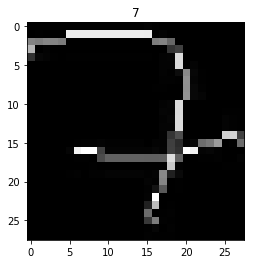

In [79]:
index = random.randint(0, image_count)
image_path = all_image_paths[index]
label = all_image_labels[index]

print(image_path)

plt.imshow(load_and_preprocess_image(image_path)[:,:,0], cmap='gray')
plt.grid(False)
plt.title(label_names[label].title())
plt.show()

In [56]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.2, random_state=101)

In [57]:
# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_ds(all_image_paths, all_image_labels):
    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    image_label_ds = ds.map(load_and_preprocess_from_path_label)

    # Setting a shuffle buffer size as large as the dataset ensures that the data is
    # completely shuffled.
    ds = image_label_ds.shuffle(buffer_size=image_count)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [58]:
train_set = create_ds(train_image_paths, train_image_labels)
test_set = create_ds(test_image_paths, test_image_labels)

## Model summary

In [64]:
cnn_model = tf.keras.Sequential(
  [
#       tf.keras.layers.Reshape(input_shape=(28,28), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same', input_shape=(28, 28, 1)),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(len(label_names), activation='softmax')
  ])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 12)        36        
_________________________________________________________________
activation_20 (Activation)   (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 24)        72        
_________________________________________________________________
activation_21 (Activation)   (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 32)         

In [1]:
# mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
# mobile_net.trainable=False

# model = tf.keras.Sequential([
#     mobile_net,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#               loss='sparse_categorical_crossentropy',
#               metrics=["accuracy"])

# model.summary()

## Customized Callback

In [59]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
#         self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
#         self.model.reset_metrics()


## TRAINING

In [65]:
# steps_per_epoch = tf.math.ceil(0.9 * image_count/BATCH_SIZE).numpy()
# val_steps_per_epoch = tf.math.ceil(0.1 * image_count/BATCH_SIZE).numpy()

steps_per_epoch = len(train_image_labels) // BATCH_SIZE
val_steps_per_epoch = len(test_image_labels) // BATCH_SIZE
batch_stats_callback = CollectBatchStats()

history = cnn_model.fit(train_set, epochs=6, 
            steps_per_epoch=steps_per_epoch,
            callbacks = [batch_stats_callback],
            validation_data=test_set,
            validation_steps=val_steps_per_epoch)

Epoch 1/6
1043/1043 [==============================] - 45s 44ms/step - loss: 0.2033 - accuracy: 0.9409 - val_loss: 0.0928 - val_accuracy: 0.9749
Epoch 2/6
1043/1043 [==============================] - 34s 32ms/step - loss: 0.0708 - accuracy: 0.9791 - val_loss: 0.0439 - val_accuracy: 0.9859
Epoch 3/6
1043/1043 [==============================] - 34s 33ms/step - loss: 0.0512 - accuracy: 0.9859 - val_loss: 0.0297 - val_accuracy: 0.9913
Epoch 4/6
1043/1043 [==============================] - 34s 33ms/step - loss: 0.0445 - accuracy: 0.9881 - val_loss: 0.0192 - val_accuracy: 0.9939
Epoch 5/6
1043/1043 [==============================] - 34s 33ms/step - loss: 0.0357 - accuracy: 0.9899 - val_loss: 0.0379 - val_accuracy: 0.9910
Epoch 6/6
1043/1043 [==============================] - 34s 32ms/step - loss: 0.0319 - accuracy: 0.9912 - val_loss: 0.0241 - val_accuracy: 0.9942


In [66]:
def plot_loss(training_losses, val_losses, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Loss")
    plt.xlabel(x_label)
    
    training_steps = len(training_losses)
    test_steps = len(val_losses)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(np.linspace(0, training_steps, test_steps), val_losses, label='Validation Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc='upper right')
    plt.show()

In [67]:
def plot_accuracy(training_acc, val_acc, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Accuracy")
    plt.xlabel(x_label)
    
    training_steps = len(training_acc)
    test_steps = len(val_acc)
    plt.plot(training_acc, label='Training Accuracy')
    plt.plot(np.linspace(0, training_steps, test_steps), val_acc, label='Validation Accuracy')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.show()

<Figure size 432x288 with 0 Axes>

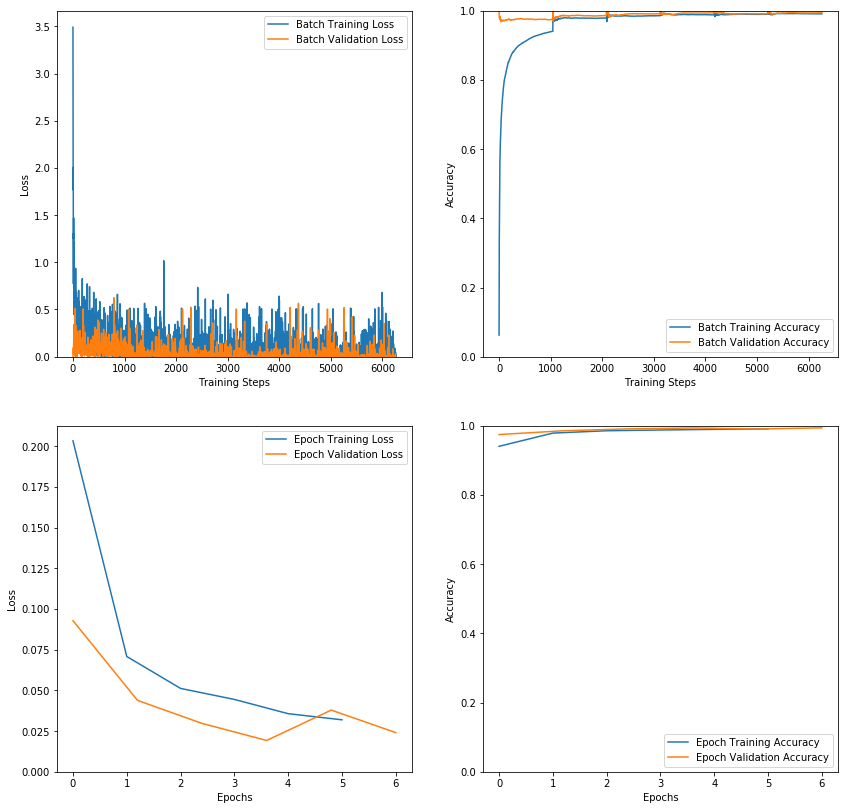

In [68]:
def plot_training_results(training_acc, training_losses, val_acc, val_losses, epoch_acc, epoch_val_acc, epoch_loss, epoch_val_loss):
    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=[14, 14])

    # Plot batch's training & validation losses
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].set_xlabel("Training Steps")

    training_steps = len(training_losses)
    test_steps = len(val_losses)
    ax[0, 0].plot(training_losses, label='Batch Training Loss')
    ax[0, 0].plot(np.linspace(0, training_steps, test_steps), val_losses, label='Batch Validation Loss')
    ax[0, 0].set_ylim([0,max(ax[0, 0].set_ylim())])
    ax[0, 0].legend(loc='upper right')

    # Plot batchs training & validation accuracy
    ax[0, 1].set_ylabel("Accuracy")
    ax[0, 1].set_xlabel("Training Steps")

    training_steps = len(training_acc)
    test_steps = len(val_acc)
    ax[0, 1].plot(training_acc, label='Batch Training Accuracy')
    ax[0, 1].plot(np.linspace(0, training_steps, test_steps), val_acc, label='Batch Validation Accuracy')
    ax[0, 1].set_ylim([0,1])
    ax[0, 1].legend(loc='lower right')

    # Plot epochs training & validation losses
    ax[1, 0].set_ylabel("Loss")
    ax[1, 0].set_xlabel("Epochs")

    train_epochs = len(epoch_loss)
    val_epochs = len(epoch_val_loss)
    ax[1, 0].plot(epoch_loss, label='Epoch Training Loss')
    ax[1, 0].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_loss, label='Epoch Validation Loss')
    ax[1, 0].set_ylim([0,max(ax[1, 0].set_ylim())])
    ax[1, 0].legend(loc='upper right')

    # Plot epochs training & validation accuracy
    ax[1, 1].set_ylabel("Accuracy")
    ax[1, 1].set_xlabel("Epochs")

    train_epochs = len(epoch_acc)
    val_epochs = len(epoch_val_acc)
    ax[1, 1].plot(epoch_acc, label='Epoch Training Accuracy')
    ax[1, 1].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_acc, label='Epoch Validation Accuracy')
    ax[1, 1].set_ylim([0,1])
    ax[1, 1].legend(loc='lower right')

    plt.show()

plot_training_results(batch_stats_callback.batch_acc,
                      batch_stats_callback.batch_losses, 
                      batch_stats_callback.batch_val_acc, 
                      batch_stats_callback.batch_val_losses,
                      history.history['accuracy'],
                      history.history['val_accuracy'],
                      history.history['loss'],
                      history.history['val_loss']
                     )

## Testing and preview

In [69]:
# Take 1 batch out to test

for image_batch, label_batch in test_set:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 28, 28, 1)
Label batch shape:  (32,)


In [70]:
# Predict
label_names = np.array(label_names)
predicted_batch = cnn_model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = label_names[predicted_id]

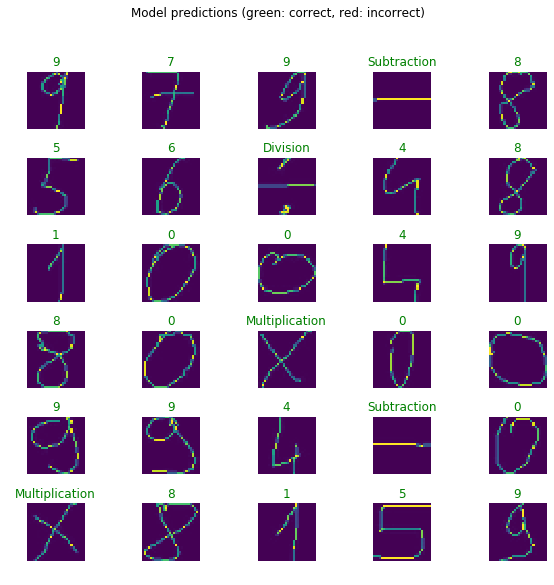

In [73]:
# Plot the result

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n][:,:,0])
    color = "green" if predicted_id[n] == label_batch.numpy()[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export model

In [74]:
# Export model

cnn_model.save('cnn_math_v1.h5')

In [75]:
# Test model

reloaded_model = tf.keras.models.load_model('cnn_math_v1.h5')
reloaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 12)        36        
_________________________________________________________________
activation_20 (Activation)   (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 24)        72        
_________________________________________________________________
activation_21 (Activation)   (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 32)         

In [76]:
result_batch = cnn_model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [77]:
abs(reloaded_result_batch - result_batch).max()

0.0